## Authors:
#### Daniel Stöckein (5018039), Alexander Triol ()

## 0. Load Data & Data understanding
- get an understanding of the data
- create dataframes for later use

In [138]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [139]:
df_X = pd.read_csv("..\datasets\data_X.csv", engine='python', sep=',', encoding='utf8')
df_Y = pd.read_csv("..\datasets\data_Y.csv", engine='python', sep=',', encoding='utf8')

In [3]:
df_X.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


### X values
- `date_time`: YYYY-MM-dd (every minute)
- `T_data_x_x`: 5 chambers each 3 sensors
- `H_data`: height
- `AH_data`: moisture content (probably in percent)

In [4]:
df_Y.head()

,date_time,quality
0,1/4/2015 0:05,392
1,1/4/2015 2:05,393
2,1/4/2015 4:05,400
3,1/4/2015 6:05,408
4,1/4/2015 8:05,405


### Y values
- `date_time`: MM/dd/YYYY (every 2 hours)
- `quality`: manual quality measurements

## 1. Data pre-processing
1.1. convert `date_time` to correct format

In [5]:
df_X['date_time'] = pd.to_datetime(df_X['date_time'])
df_Y['date_time'] = pd.to_datetime(df_Y['date_time'])

print(df_Y.loc[df_Y['date_time'] == '2015-01-04 00:05:00'])
print(df_X.loc[df_X['date_time'] == '2015-01-04 00:05:00'])

            date_time  quality
0 2015-01-04 00:05:00      392
               date_time  T_data_1_1  T_data_1_2  T_data_1_3  T_data_2_1  \
4325 2015-01-04 00:05:00         277         326         273         322   

      T_data_2_2  T_data_2_3  T_data_3_1  T_data_3_2  T_data_3_3  T_data_4_1  \
4325         335         352         505         501         670         326   

      T_data_4_2  T_data_4_3  T_data_5_1  T_data_5_2  T_data_5_3  H_data  \
4325         379         337         231         236         242  153.77   

      AH_data  
4325      7.9  


1.1 merge dataframes on `date_time`<br>
- - **option 1: simple merge and drop x values when dont match**
- - **?? option 2 ??: aggregate x values 2-hourly -> calculate the average** (not sure if this is allowed / makes sense)
- - the merged dataframe should have same length as `data_Y`, because otherwise we would have features without label

In [6]:
df_XY = df_Y.merge(df_X, left_on='date_time', right_on='date_time', how='left') 

print(len(df_Y.index))
print(len(df_XY.index))
df_XY.head()

8512
8512


,date_time,quality,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-04 00:05:00,392,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90
1,2015-01-04 02:05:00,393,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29
2,2015-01-04 04:05:00,400,236,238,245,323,320,318,522,501,524,343,371,344,264,263,265,195.71,7.97
3,2015-01-04 06:05:00,408,215,207,210,310,321,306,510,498,478,336,349,342,270,269,271,194.18,8.63
4,2015-01-04 08:05:00,405,183,211,210,311,309,305,502,503,541,361,342,347,260,260,268,196.06,7.17


1.3 split dataframes in features and labels -> `df_features`, `df_labels`

In [7]:
df_labels = df_XY.iloc[:, 1:2]
df_labels.head()

,quality
0,392
1,393
2,400
3,408
4,405


In [8]:
df_features = df_XY.iloc[:, 2:]
df_features.head()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90
1,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29
2,236,238,245,323,320,318,522,501,524,343,371,344,264,263,265,195.71,7.97
3,215,207,210,310,321,306,510,498,478,336,349,342,270,269,271,194.18,8.63
4,183,211,210,311,309,305,502,503,541,361,342,347,260,260,268,196.06,7.17


1.4 normalize features using mean normalization

In [21]:
df_features_norm = (df_features - df_features.mean()) / df_features.std()
df_features_norm.head()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,0.844285,2.473453,0.752676,-0.718935,-0.361374,0.048407,0.063792,0.006675,2.745952,-0.575002,0.760325,-0.332026,-0.627868,-0.446915,-0.266990,-1.470630,0.346687
1,0.379363,-1.014378,0.328458,-0.616823,-0.336312,-0.512847,0.063792,-0.024776,-0.961223,-0.044844,1.261389,-0.462115,-0.227335,0.044805,-0.333337,-1.499285,-0.181469
2,-0.426503,-0.368483,-0.161026,-0.693407,-0.737302,-0.818985,0.336440,0.006675,0.361601,-0.145827,0.559900,-0.149900,0.473598,0.438181,0.496001,1.460551,0.407295
3,-1.077395,-1.369620,-1.303153,-1.025269,-0.712240,-1.125123,0.143983,-0.040502,-0.389632,-0.322546,0.008730,-0.201936,0.673865,0.634869,0.695042,1.353620,0.978743
4,-2.069229,-1.240441,-1.303153,-0.999741,-1.012983,-1.150635,0.015678,0.038126,0.639231,0.308594,-0.166643,-0.071846,0.340087,0.339837,0.595522,1.485013,-0.285369


1.5 create tensors
- convert dataframe to tensor

In [11]:
tens_features = torch.tensor(df_features.values, dtype=torch.float32)
tens_features[0]

tensor([277.0000, 326.0000, 273.0000, 322.0000, 335.0000, 352.0000, 505.0000,
        501.0000, 670.0000, 326.0000, 379.0000, 337.0000, 231.0000, 236.0000,
        242.0000, 153.7700,   7.9000])

In [13]:
tens_features_norm = torch.tensor(df_features_norm.values, dtype=torch.float32)
tens_features_norm[0]

tensor([ 0.8443,  2.4735,  0.7527, -0.7189, -0.3614,  0.0484,  0.0638,  0.0067,
         2.7460, -0.5750,  0.7603, -0.3320, -0.6279, -0.4469, -0.2670, -1.4706,
         0.3467])

In [14]:
tens_labels = torch.tensor(df_labels.values, dtype=torch.float32)
tens_labels[0]

tensor([392.])

1.6 Plot features
- Just some simple scatter plots to get familiar with the data

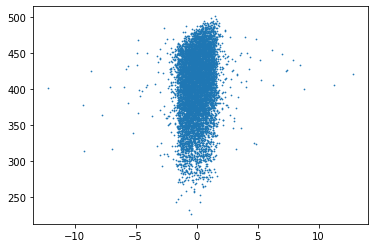

In [22]:
plt.scatter(df_features_norm['T_data_1_1'], df_labels, .5) # plot data on labels

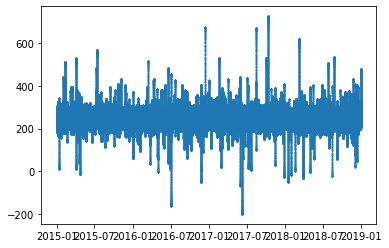

In [23]:
plt.scatter(df_X['date_time'], df_X['T_data_1_1'], .5) # plot sensor data on date_time

### Summarize
... so we dont get lost in variable names
- `df_X`: Orignal X-Data
- `df_Y`: Original Y-Data
- `df_XY`: Merged X- & Y-Data
- `df_features`: Features as Dataframe
- `df_features_norm`: Normalized features as Dataframe
- `df_labels`: Labels as Dataframe
- `tens_features`: Features as Tensor
- `tens_features_norm`: Normalized features as Tensor
- `tens_labels`: Labels as Tensor

## 2. Read the dataset in batches

In [24]:
def iter_minibatches(features, labels, batch_size: int):
    
    if features.shape[0] != labels.shape[0]: # first, check if X, y have same shape
        raise Exception('Uneven shapes')
    
    indices = np.arange(features.shape[0]) # create array with same lenght as features (0...8511)
    np.random.shuffle(indices) # shuffle those indices (in-place operation)

    for start_index in range(0, features.shape[0], batch_size): # 0 to 8511 with 10 step
        end_index = min(start_index + batch_size, features.shape[0]) # get the end index by using min: (0 + 10, 8512) = 10, ..., (8510 + 10, 8512) = 8512
        shuff_indices = indices[start_index:end_index] # contains shuffled indices in batch-size
        yield features[shuff_indices], labels[shuff_indices] # return shuffled features & labels but remember iter-position

## 3. Model definition (Linear Regression NN)

3.1 compute $\hat{y}$
- Recall: Matrix-Vector dot product
- - $ \mathbf{X}\mathbf{w} $ will produce a **vector**
- - $ b $ is a **scalar**
- - $ \hat{y} $ will be a **vector**
$$\hat{y} = \mathbf{X}\mathbf{w} + b$$

In [25]:
def lin_reg_nn(features, weights, bias):
    return torch.matmul(features, weights) + bias

## 4. Loss function definition (Mean squared error)
4.1 now use $\hat{y}$ to compute the error / loss

$$\mathcal{L} = \frac{1}{n} \sum_{i = 1}^{n} (y^{(i)} - \hat{y}^{(i)})^2$$

In [26]:
def mse_loss(y, y_pred):
    return ((y - y_pred)**2).mean()

## 5. Optimization algorithm (minibatch stochastic gradient descent)
5.1 finally, use an optimization algorithm to adjust weights (-> to lower error)
$$ \mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla_w $$

- `parameters`: tensor contains weights, bias which we want to update
- `learning_rate`: determines how *strong* the optimization will be
- `torch.no_grad()`: to keep the update out of the gradient computation
- - Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
- `parameters.grad`: gradient attribute of a tensor -> `torch.Tensor.grad`
- `grad.zero_()`: Tell PyTorch to let it go (the gradient)

In [69]:
def stoch_grad_desc(parameters, learning_rate, batch_size):
    with torch.no_grad():
         for parameter in parameters:
                parameter -= learning_rate * parameter.grad / batch_size
                parameter.grad.zero_() # in-place operation _

## 6. Training procedure
```{r, tidy=FALSE, eval=FALSE, highlight=FALSE }

for each epoch:
    for each batch:
        calculate loss
        compute gradient
        update parameters
```

6.2 Create training procedure

- **hyper parameters**: optimized manually
- **model parameters**: optimized (learned) by the model
- - `required_grad=True`: for gradient computation in PyTorch
- - `weights`: The rows of the weight-vector should be equal to the amount of features
- - `bias`: scalar with 0 initialization

- `loss.backward()`: computes dloss/dx for every parameter x which has `requires_grad=True`. These are accumulated into `x.grad` for every parameter x. https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944. By default, pytorch expects `backward()` to be called for the last output of the network - the loss function. https://stackoverflow.com/questions/57248777/backward-function-in-pytorch/57249287#57249287. If your loss is not a scalar value, then you should certainly use either `loss.mean()` or `loss.sum()` to convert it to a scalar before calling the backward. Otherwise, it will cause an error. https://discuss.pytorch.org/t/should-i-do-loss-backward-or-loss-mean-backward/35622

In [101]:
def train(epochs, learning_rate, batch_size, features ,labels):
    # model parameters
    weights = torch.randn(tens_features.shape[1], 1, requires_grad=True, dtype=torch.float32)
    bias = torch.randn(1, requires_grad=True) 
    
    batch_losses = [] # list of batch_losses per epoch
    
    for epoch in range(epochs):
        
        bl_sum = 0 # sum of all batch_losses per epoch
        
        for i, (X, y) in enumerate(iter_minibatches(features, labels, batch_size)): # i = counter
            
            y_pred = lin_reg_nn(X, weights, bias) # make prediction
            batch_loss = mse_loss(y, y_pred) # loss for each batch
            bl_sum += batch_loss # sum of batch losses
            batch_loss.backward() # backpropagate
            
            parameters = weights, bias # tuple
            stoch_grad_desc(parameters, learning_rate, batch_size) # update parameters
          
        batch_losses.append(bl_sum.item() / i) # average loss
        
        with torch.no_grad(): # entire dataset
            y_pred_train = lin_reg_nn(features, weights, bias)
            train_loss = mse_loss(y_pred_train, labels)
            print(epoch, train_loss.mean())
        
    return batch_losses

## 7. Playground
1. Attempt
- - random parameters

In [104]:
# hyper parameters
learning_rate = 0.001
epochs = 600
batch_size = 50

batch_losses = train(epochs, learning_rate, batch_size, tens_features, tens_labels)

0 tensor(nan)
1 tensor(nan)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(nan)
67 te

525 tensor(nan)
526 tensor(nan)
527 tensor(nan)
528 tensor(nan)
529 tensor(nan)
530 tensor(nan)
531 tensor(nan)
532 tensor(nan)
533 tensor(nan)
534 tensor(nan)
535 tensor(nan)
536 tensor(nan)
537 tensor(nan)
538 tensor(nan)
539 tensor(nan)
540 tensor(nan)
541 tensor(nan)
542 tensor(nan)
543 tensor(nan)
544 tensor(nan)
545 tensor(nan)
546 tensor(nan)
547 tensor(nan)
548 tensor(nan)
549 tensor(nan)
550 tensor(nan)
551 tensor(nan)
552 tensor(nan)
553 tensor(nan)
554 tensor(nan)
555 tensor(nan)
556 tensor(nan)
557 tensor(nan)
558 tensor(nan)
559 tensor(nan)
560 tensor(nan)
561 tensor(nan)
562 tensor(nan)
563 tensor(nan)
564 tensor(nan)
565 tensor(nan)
566 tensor(nan)
567 tensor(nan)
568 tensor(nan)
569 tensor(nan)
570 tensor(nan)
571 tensor(nan)
572 tensor(nan)
573 tensor(nan)
574 tensor(nan)
575 tensor(nan)
576 tensor(nan)
577 tensor(nan)
578 tensor(nan)
579 tensor(nan)
580 tensor(nan)
581 tensor(nan)
582 tensor(nan)
583 tensor(nan)
584 tensor(nan)
585 tensor(nan)
586 tensor(nan)
587 tens

2. Attempt
- - The `learning_rate` was probably to high -> causing NaN's and inf's

In [110]:
# hyper parameters
learning_rate = 0.000001
epochs = 600
batch_size = 50

batch_losses = train(epochs, learning_rate, batch_size, tens_features, tens_labels)

0 tensor(33764.6406)
1 tensor(32619.5566)
2 tensor(31477.9102)
3 tensor(30486.9336)
4 tensor(29433.4238)
5 tensor(28427.7285)
6 tensor(27542.7285)
7 tensor(26642.5195)
8 tensor(25740.6191)
9 tensor(24956.2598)
10 tensor(24126.4727)
11 tensor(23395.4844)
12 tensor(22667.3262)
13 tensor(21948.8945)
14 tensor(21272.8750)
15 tensor(20632.7637)
16 tensor(20048.5449)
17 tensor(19443.4980)
18 tensor(18836.0469)
19 tensor(18291.8516)
20 tensor(17761.2656)
21 tensor(17284.1328)
22 tensor(16765.8750)
23 tensor(16306.3105)
24 tensor(15827.8516)
25 tensor(15386.8213)
26 tensor(14965.7070)
27 tensor(14561.9395)
28 tensor(14169.6631)
29 tensor(13791.1064)
30 tensor(13434.3545)
31 tensor(13076.1338)
32 tensor(12750.4121)
33 tensor(12412.0625)
34 tensor(12093.6221)
35 tensor(11788.9170)
36 tensor(11501.5000)
37 tensor(11212.3066)
38 tensor(10942.0967)
39 tensor(10675.0801)
40 tensor(10428.2490)
41 tensor(10167.7568)
42 tensor(9932.8877)
43 tensor(9722.6768)
44 tensor(9477.4824)
45 tensor(9275.6367)
46

377 tensor(1187.7640)
378 tensor(1186.2808)
379 tensor(1183.2078)
380 tensor(1181.4126)
381 tensor(1180.8318)
382 tensor(1179.8357)
383 tensor(1176.8789)
384 tensor(1174.7085)
385 tensor(1173.1372)
386 tensor(1170.8851)
387 tensor(1169.6714)
388 tensor(1168.9833)
389 tensor(1165.8513)
390 tensor(1168.1425)
391 tensor(1162.5129)
392 tensor(1160.8455)
393 tensor(1159.2678)
394 tensor(1157.6484)
395 tensor(1156.0199)
396 tensor(1157.5585)
397 tensor(1152.8704)
398 tensor(1151.1703)
399 tensor(1149.6619)
400 tensor(1150.0496)
401 tensor(1146.6469)
402 tensor(1144.9254)
403 tensor(1143.4020)
404 tensor(1143.0770)
405 tensor(1142.3379)
406 tensor(1138.8334)
407 tensor(1140.2671)
408 tensor(1136.4583)
409 tensor(1134.5099)
410 tensor(1133.8226)
411 tensor(1132.4606)
412 tensor(1130.5288)
413 tensor(1128.9121)
414 tensor(1127.2993)
415 tensor(1125.6990)
416 tensor(1125.1360)
417 tensor(1129.6249)
418 tensor(1123.9042)
419 tensor(1121.8075)
420 tensor(1119.6560)
421 tensor(1118.9403)
422 tensor

Text(0.5, 0, 'epochs')

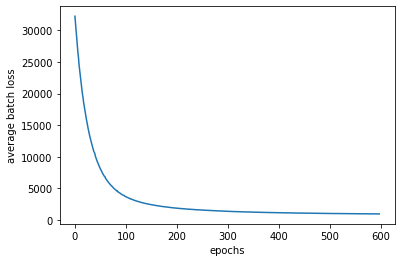

In [111]:
plt.plot(batch_losses[2:])
plt.ylabel("average batch loss")
plt.xlabel("epochs")

3. Attempt
- - The error is decreasing which means the model is learning
- - Adjusting other parameters

In [112]:
# hyper parameters
learning_rate = 0.0001
epochs = 1000
batch_size = 256

batch_losses = train(epochs, learning_rate, batch_size, tens_features, tens_labels)

0 tensor(18485.5508)
1 tensor(16373.7891)
2 tensor(15222.7188)
3 tensor(13937.8945)
4 tensor(12993.7627)
5 tensor(12322.9971)
6 tensor(12498.7734)
7 tensor(10781.5508)
8 tensor(10211.1309)
9 tensor(9691.9355)
10 tensor(9344.5527)
11 tensor(8805.8779)
12 tensor(8444.4795)
13 tensor(8251.8564)
14 tensor(7756.8140)
15 tensor(7488.9922)
16 tensor(8273.8721)
17 tensor(6884.6924)
18 tensor(6507.9058)
19 tensor(6175.5977)
20 tensor(5939.9072)
21 tensor(5714.2275)
22 tensor(5452.4233)
23 tensor(5245.9873)
24 tensor(5274.1147)
25 tensor(5264.7231)
26 tensor(4737.3784)
27 tensor(4483.6313)
28 tensor(4372.5151)
29 tensor(4159.1821)
30 tensor(4008.9385)
31 tensor(4107.0898)
32 tensor(3835.8787)
33 tensor(3893.8289)
34 tensor(3701.8843)
35 tensor(3527.0283)
36 tensor(3240.6582)
37 tensor(3143.9731)
38 tensor(3132.0869)
39 tensor(2936.5520)
40 tensor(2967.8586)
41 tensor(2806.0015)
42 tensor(2675.5220)
43 tensor(2658.9377)
44 tensor(2579.9255)
45 tensor(2438.0308)
46 tensor(2628.6650)
47 tensor(2311

404 tensor(820.1663)
405 tensor(919.6455)
406 tensor(816.0575)
407 tensor(835.7115)
408 tensor(812.7228)
409 tensor(932.4329)
410 tensor(813.6122)
411 tensor(911.3614)
412 tensor(936.2206)
413 tensor(812.5524)
414 tensor(819.0229)
415 tensor(822.4487)
416 tensor(818.8973)
417 tensor(858.6133)
418 tensor(813.0481)
419 tensor(817.2631)
420 tensor(812.2526)
421 tensor(866.8862)
422 tensor(878.7508)
423 tensor(832.4131)
424 tensor(924.7542)
425 tensor(860.0335)
426 tensor(826.0257)
427 tensor(819.2856)
428 tensor(818.0208)
429 tensor(817.9685)
430 tensor(813.1967)
431 tensor(827.6067)
432 tensor(815.9387)
433 tensor(822.4874)
434 tensor(812.4282)
435 tensor(813.9066)
436 tensor(832.6929)
437 tensor(819.0603)
438 tensor(819.1849)
439 tensor(819.6675)
440 tensor(884.9880)
441 tensor(849.9947)
442 tensor(874.3148)
443 tensor(826.8074)
444 tensor(812.7396)
445 tensor(833.7145)
446 tensor(811.9388)
447 tensor(823.5584)
448 tensor(812.5112)
449 tensor(820.0030)
450 tensor(973.9970)
451 tensor(82

804 tensor(819.7858)
805 tensor(813.6064)
806 tensor(824.6754)
807 tensor(864.2745)
808 tensor(866.6531)
809 tensor(814.2538)
810 tensor(813.4001)
811 tensor(816.4916)
812 tensor(812.4780)
813 tensor(824.8223)
814 tensor(817.8195)
815 tensor(812.1760)
816 tensor(823.2964)
817 tensor(835.1336)
818 tensor(814.4131)
819 tensor(811.0560)
820 tensor(819.4787)
821 tensor(902.0123)
822 tensor(868.9512)
823 tensor(810.8950)
824 tensor(814.0977)
825 tensor(922.7679)
826 tensor(843.8525)
827 tensor(818.4850)
828 tensor(824.8944)
829 tensor(851.0450)
830 tensor(827.9435)
831 tensor(811.1144)
832 tensor(851.5863)
833 tensor(815.0370)
834 tensor(812.3698)
835 tensor(858.4223)
836 tensor(815.0808)
837 tensor(819.3415)
838 tensor(832.1255)
839 tensor(865.9032)
840 tensor(818.6839)
841 tensor(821.8351)
842 tensor(886.2090)
843 tensor(810.9118)
844 tensor(811.6863)
845 tensor(849.7446)
846 tensor(858.3430)
847 tensor(884.0930)
848 tensor(845.6402)
849 tensor(873.4913)
850 tensor(817.6968)
851 tensor(89

Text(0.5, 0, 'epochs')

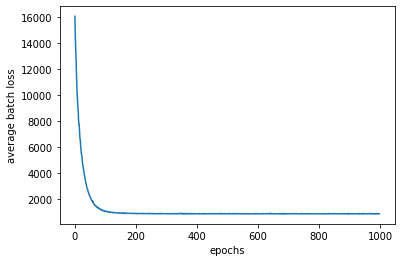

In [113]:
plt.plot(batch_losses[2:])
plt.ylabel("average batch loss")
plt.xlabel("epochs")

4. Attempt
- - at a certain point of epochs the model stoped learning, use this

In [126]:
# hyper parameters
learning_rate = 0.0001
epochs = 270
batch_size = 256

batch_losses = train(epochs, learning_rate, batch_size, tens_features, tens_labels)

0 tensor(25172.8730)
1 tensor(20510.8066)
2 tensor(16972.7520)
3 tensor(14471.9141)
4 tensor(13426.7588)
5 tensor(10697.0908)
6 tensor(9471.6387)
7 tensor(8433.7715)
8 tensor(7397.3882)
9 tensor(6598.6245)
10 tensor(6203.6099)
11 tensor(5646.1187)
12 tensor(5036.6973)
13 tensor(4561.7437)
14 tensor(4401.6504)
15 tensor(4136.0356)
16 tensor(3780.5789)
17 tensor(3421.1770)
18 tensor(3182.6299)
19 tensor(2991.5137)
20 tensor(2993.4468)
21 tensor(2680.3188)
22 tensor(2615.5161)
23 tensor(2405.6763)
24 tensor(2342.2476)
25 tensor(2213.9985)
26 tensor(2360.6047)
27 tensor(2231.4075)
28 tensor(2123.9978)
29 tensor(1856.1287)
30 tensor(1915.3666)
31 tensor(1732.0813)
32 tensor(1714.8961)
33 tensor(1839.9833)
34 tensor(1574.7655)
35 tensor(1527.8966)
36 tensor(1488.7081)
37 tensor(1751.9426)
38 tensor(1448.3895)
39 tensor(1438.6219)
40 tensor(1360.3254)
41 tensor(1335.3816)
42 tensor(1309.5562)
43 tensor(1373.7274)
44 tensor(1284.3013)
45 tensor(1240.6072)
46 tensor(1375.5488)
47 tensor(1219.21

Text(0.5, 0, 'epochs')

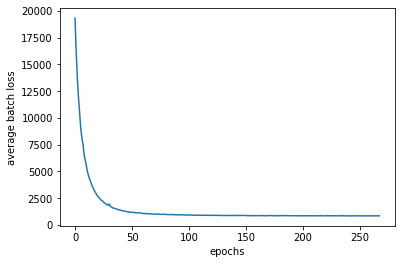

In [127]:
plt.plot(batch_losses[2:])
plt.ylabel("average batch loss")
plt.xlabel("epochs")

### 7.1 Using normalized data
- `tens_features_norm`
1. Attempt
- - Starting with the same parameters as above

In [128]:
# hyper parameters
learning_rate = 0.0001
epochs = 1000
batch_size = 256

batch_losses = train(epochs, learning_rate, batch_size, tens_features_norm, tens_labels)

0 tensor(164305.8906)
1 tensor(164297.0625)
2 tensor(164288.2656)
3 tensor(164279.4688)
4 tensor(164270.6406)
5 tensor(164261.8594)
6 tensor(164253.0625)
7 tensor(164244.2812)
8 tensor(164235.4531)
9 tensor(164226.6719)
10 tensor(164217.8906)
11 tensor(164209.0938)
12 tensor(164200.2812)
13 tensor(164191.5000)
14 tensor(164182.7031)
15 tensor(164173.9219)
16 tensor(164165.1094)
17 tensor(164156.3281)
18 tensor(164147.5312)
19 tensor(164138.7344)
20 tensor(164129.9219)
21 tensor(164121.1562)
22 tensor(164112.3594)
23 tensor(164103.5938)
24 tensor(164094.7812)
25 tensor(164085.9844)
26 tensor(164077.2188)
27 tensor(164068.4219)
28 tensor(164059.6406)
29 tensor(164050.8438)
30 tensor(164042.0312)
31 tensor(164033.2500)
32 tensor(164024.4531)
33 tensor(164015.6719)
34 tensor(164006.8750)
35 tensor(163998.1094)
36 tensor(163989.3281)
37 tensor(163980.5469)
38 tensor(163971.7656)
39 tensor(163962.9688)
40 tensor(163954.1875)
41 tensor(163945.3906)
42 tensor(163936.5938)
43 tensor(163927.8281

368 tensor(161098.6875)
369 tensor(161090.0625)
370 tensor(161081.4219)
371 tensor(161072.8125)
372 tensor(161064.2031)
373 tensor(161055.5781)
374 tensor(161046.9375)
375 tensor(161038.3125)
376 tensor(161029.7031)
377 tensor(161021.0469)
378 tensor(161012.4219)
379 tensor(161003.7969)
380 tensor(160995.2031)
381 tensor(160986.5781)
382 tensor(160977.9844)
383 tensor(160969.3438)
384 tensor(160960.7031)
385 tensor(160952.0938)
386 tensor(160943.4688)
387 tensor(160934.8750)
388 tensor(160926.2500)
389 tensor(160917.6406)
390 tensor(160909.0469)
391 tensor(160900.4219)
392 tensor(160891.7969)
393 tensor(160883.1719)
394 tensor(160874.5625)
395 tensor(160865.9531)
396 tensor(160857.3438)
397 tensor(160848.7031)
398 tensor(160840.0938)
399 tensor(160831.4844)
400 tensor(160822.8750)
401 tensor(160814.2500)
402 tensor(160805.6406)
403 tensor(160797.0156)
404 tensor(160788.4219)
405 tensor(160779.8125)
406 tensor(160771.1875)
407 tensor(160762.5938)
408 tensor(160753.9688)
409 tensor(16074

713 tensor(158149.8906)
714 tensor(158141.4062)
715 tensor(158132.9531)
716 tensor(158124.5000)
717 tensor(158116.0312)
718 tensor(158107.5625)
719 tensor(158099.0938)
720 tensor(158090.6406)
721 tensor(158082.1719)
722 tensor(158073.7344)
723 tensor(158065.2656)
724 tensor(158056.7812)
725 tensor(158048.3281)
726 tensor(158039.8594)
727 tensor(158031.4062)
728 tensor(158022.9375)
729 tensor(158014.5000)
730 tensor(158006.)
731 tensor(157997.5312)
732 tensor(157989.0938)
733 tensor(157980.6406)
734 tensor(157972.1719)
735 tensor(157963.7031)
736 tensor(157955.2500)
737 tensor(157946.7969)
738 tensor(157938.3281)
739 tensor(157929.8750)
740 tensor(157921.4062)
741 tensor(157912.9375)
742 tensor(157904.4844)
743 tensor(157896.0312)
744 tensor(157887.5781)
745 tensor(157879.1250)
746 tensor(157870.6719)
747 tensor(157862.2031)
748 tensor(157853.7656)
749 tensor(157845.2969)
750 tensor(157836.8594)
751 tensor(157828.3906)
752 tensor(157819.9375)
753 tensor(157811.5156)
754 tensor(157803.06

Text(0.5, 0, 'epochs')

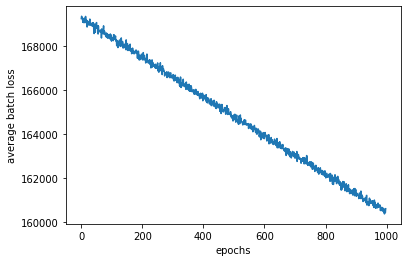

In [129]:
plt.plot(batch_losses[2:])
plt.ylabel("average batch loss")
plt.xlabel("epochs")

2. Attempt
- - We can easily increase the `learning_rate`

In [130]:
# hyper parameters
learning_rate = 0.1
epochs = 1000
batch_size = 256

batch_losses = train(epochs, learning_rate, batch_size, tens_features_norm, tens_labels)

0 tensor(156238.9531)
1 tensor(148106.5469)
2 tensor(140401.0156)
3 tensor(133096.9375)
4 tensor(126186.6328)
5 tensor(119640.4141)
6 tensor(113427.5781)
7 tensor(107549.3906)
8 tensor(101975.5156)
9 tensor(96694.2266)
10 tensor(91689.7031)
11 tensor(86947.8125)
12 tensor(82450.8828)
13 tensor(78191.5469)
14 tensor(74151.4844)
15 tensor(70329.1016)
16 tensor(66702.2266)
17 tensor(63264.2188)
18 tensor(60004.9219)
19 tensor(56914.4844)
20 tensor(53985.6250)
21 tensor(51209.3242)
22 tensor(48576.8047)
23 tensor(46081.4688)
24 tensor(43717.6562)
25 tensor(41477.2148)
26 tensor(39353.6016)
27 tensor(37338.9492)
28 tensor(35428.9570)
29 tensor(33618.6484)
30 tensor(31903.3086)
31 tensor(30274.9902)
32 tensor(28732.9941)
33 tensor(27270.4434)
34 tensor(25884.5410)
35 tensor(24570.4609)
36 tensor(23324.6016)
37 tensor(22142.6973)
38 tensor(21021.7051)
39 tensor(19959.3672)
40 tensor(18952.1836)
41 tensor(17998.6113)
42 tensor(17093.1348)
43 tensor(16235.3906)
44 tensor(15421.6074)
45 tensor(1

402 tensor(519.9605)
403 tensor(519.9600)
404 tensor(519.9600)
405 tensor(519.9597)
406 tensor(519.9596)
407 tensor(519.9599)
408 tensor(519.9593)
409 tensor(519.9590)
410 tensor(519.9587)
411 tensor(519.9586)
412 tensor(519.9588)
413 tensor(519.9619)
414 tensor(519.9606)
415 tensor(519.9598)
416 tensor(519.9595)
417 tensor(519.9584)
418 tensor(519.9581)
419 tensor(519.9586)
420 tensor(519.9614)
421 tensor(519.9609)
422 tensor(519.9620)
423 tensor(519.9622)
424 tensor(519.9608)
425 tensor(519.9597)
426 tensor(519.9590)
427 tensor(519.9591)
428 tensor(519.9595)
429 tensor(519.9601)
430 tensor(519.9595)
431 tensor(519.9623)
432 tensor(519.9612)
433 tensor(519.9602)
434 tensor(519.9597)
435 tensor(519.9600)
436 tensor(519.9595)
437 tensor(519.9590)
438 tensor(519.9601)
439 tensor(519.9596)
440 tensor(519.9586)
441 tensor(519.9605)
442 tensor(519.9596)
443 tensor(519.9587)
444 tensor(519.9586)
445 tensor(519.9584)
446 tensor(519.9581)
447 tensor(519.9573)
448 tensor(519.9575)
449 tensor(51

808 tensor(519.9565)
809 tensor(519.9563)
810 tensor(519.9564)
811 tensor(519.9572)
812 tensor(519.9567)
813 tensor(519.9564)
814 tensor(519.9564)
815 tensor(519.9565)
816 tensor(519.9566)
817 tensor(519.9565)
818 tensor(519.9565)
819 tensor(519.9563)
820 tensor(519.9561)
821 tensor(519.9562)
822 tensor(519.9565)
823 tensor(519.9570)
824 tensor(519.9569)
825 tensor(519.9559)
826 tensor(519.9559)
827 tensor(519.9562)
828 tensor(519.9559)
829 tensor(519.9561)
830 tensor(519.9561)
831 tensor(519.9565)
832 tensor(519.9560)
833 tensor(519.9558)
834 tensor(519.9554)
835 tensor(519.9554)
836 tensor(519.9557)
837 tensor(519.9559)
838 tensor(519.9564)
839 tensor(519.9560)
840 tensor(519.9560)
841 tensor(519.9557)
842 tensor(519.9556)
843 tensor(519.9557)
844 tensor(519.9559)
845 tensor(519.9557)
846 tensor(519.9568)
847 tensor(519.9564)
848 tensor(519.9564)
849 tensor(519.9563)
850 tensor(519.9565)
851 tensor(519.9559)
852 tensor(519.9559)
853 tensor(519.9557)
854 tensor(519.9558)
855 tensor(51

Text(0.5, 0, 'epochs')

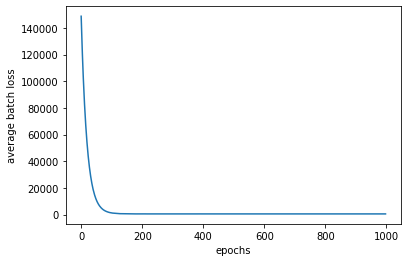

In [131]:
plt.plot(batch_losses[2:])
plt.ylabel("average batch loss")
plt.xlabel("epochs")

3. Attempt
- - finally decrease the amount of epochs around the point where the model stoped learning

In [134]:
# hyper parameters
learning_rate = 0.1
epochs = 150
batch_size = 256

batch_losses = train(epochs, learning_rate, batch_size, tens_features_norm, tens_labels)

0 tensor(155678.6562)
1 tensor(147581.2500)
2 tensor(139892.8750)
3 tensor(132615.7500)
4 tensor(125717.3984)
5 tensor(119195.0234)
6 tensor(113007.7734)
7 tensor(107148.8359)
8 tensor(101591.6875)
9 tensor(96328.6172)
10 tensor(91338.7031)
11 tensor(86609.2734)
12 tensor(82125.2969)
13 tensor(77883.3906)
14 tensor(73863.0078)
15 tensor(70052.2578)
16 tensor(66439.8359)
17 tensor(63014.6172)
18 tensor(59770.5039)
19 tensor(56692.3203)
20 tensor(53775.4648)
21 tensor(51010.4414)
22 tensor(48389.1641)
23 tensor(45905.7734)
24 tensor(43550.2695)
25 tensor(41315.9531)
26 tensor(39200.2812)
27 tensor(37194.6133)
28 tensor(35291.7734)
29 tensor(33490.1875)
30 tensor(31781.3867)
31 tensor(30160.2109)
32 tensor(28625.0156)
33 tensor(27168.6191)
34 tensor(25785.8301)
35 tensor(24475.2754)
36 tensor(23234.1387)
37 tensor(22056.3379)
38 tensor(20940.4805)
39 tensor(19882.4590)
40 tensor(18879.6504)
41 tensor(17927.8770)
42 tensor(17025.2109)
43 tensor(16169.6621)
44 tensor(15358.6729)
45 tensor(1

Text(0.5, 0, 'epochs')

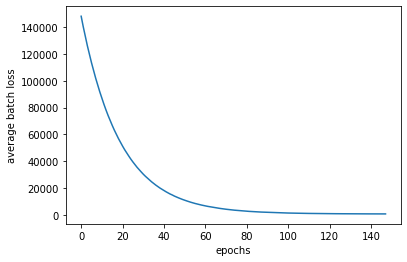

In [135]:
plt.plot(batch_losses[2:])
plt.ylabel("average batch loss")
plt.xlabel("epochs")

## 8. Conclusion
The unnormalized Dataset requires a pretty low learning rate. That is probably due to the fact, that the range of values vary greatly. With the initial learning rate of 0.001 the model was not able to compute the mean squared error, because the learning rate was causing the values to jump out of range. With a relative low learning rate of 0.000001 we were able to train the model with a reasonable amount of epochs. In our 2. attempt we used 600 epochs and a batch size of 50 and noticed a steady descrease of the error. In our 3. attempt we adjusted the batch size and increased the number of epochs, just to see if we could lower the error even more. With the higher batch size, the average batch loss was lower and the model stoped learning at around 250 epochs. Lastly we used the mean normalized features allowing us to greatly increase the learning rate and descrease the number of epochs. 